In [ ]:
# region import
import numpy as np
import pandas as pd
from backtesting import Strategy, Backtest
import joblib
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from backtesting import Backtest
# endregion

/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [ ]:
class ElderImpulseADX(Strategy):
    multi = 4
    threshold = -4
    entry_pct = 1

    def init(self):
        close = pd.Series(self.data.Close)
        high = pd.Series(self.data.High)
        low = pd.Series(self.data.Low)
        src = talib.WMA(close, timeperiod=20)
        
        # === VOLA ===
        rets = close.pct_change()
        f_volatility = rets.ewm(self.multi * 30).std()
        s_volatility = rets.rolling(window=self.multi * 365).std()
        vola_ratio = f_volatility / s_volatility

        # === MACD ===
        ema_fast = src.ewm(span=12 * self.multi, adjust=False).mean()
        ema_slow = src.ewm(span=26 * self.multi, adjust=False).mean()
        macd = ema_fast - ema_slow
        macd_signal = macd.ewm(span=9 * self.multi, adjust=False).mean()
        macd_hist = (macd - macd_signal).shift(1)

        # === EMA Trend ===
        ema_val = src.ewm(span=21 * self.multi, adjust=False).mean().shift(1)

        # === Directional Movement (+DI, -DI, ADX) ===
        up = high.diff()
        down = -low.diff()
        plusDM = np.where((up > down) & (up > 0), up, 0.0)
        minusDM = np.where((down > up) & (down > 0), down, 0.0)

        tr = np.maximum.reduce([
            (high - low).to_numpy(),
            (high - close.shift()).abs().to_numpy(),
            (low - close.shift()).abs().to_numpy()
        ])

        atr = pd.Series(tr).rolling(14 * self.multi, min_periods=1).mean()

        plusDI = (100 * pd.Series(plusDM).rolling(14 * self.multi, min_periods=1).mean() / atr).shift(1)
        minusDI = (100 * pd.Series(minusDM).rolling(14 * self.multi, min_periods=1).mean() / atr).shift(1)

        dx = (100 * (plusDI - minusDI).abs() / (plusDI + minusDI)).fillna(0)
        adx = dx.rolling(14 * self.multi, min_periods=1).mean().shift(1)

        # === Store indicators ===
        atr = talib.ATR(high.to_numpy(), low.to_numpy(), close.to_numpy(), timeperiod=14*self.multi)
        self.kelly = self.I(lambda: vola_ratio.to_numpy())
        self.macd_hist = self.I(lambda: macd_hist.to_numpy(), plot = False) / atr
        self.ema_val = self.I(lambda: ema_val.to_numpy())
        self.plusDI = self.I(lambda: plusDI.to_numpy(), plot=False)
        self.minusDI = self.I(lambda: minusDI.to_numpy(), plot=False)
        self.adx = self.I(lambda: adx.to_numpy(), plot=False)
        
    def next(self):
        bull = (self.ema_val[-1] > self.ema_val[-2]) and \
               (self.macd_hist[-1] > self.macd_hist[-2]) and \
               (self.plusDI[-1] > self.minusDI[-1] + self.threshold) and \
               (self.adx[-1] >= 6)

        bear = (self.ema_val[-1] < self.ema_val[-2]) and \
               (self.macd_hist[-1] < self.macd_hist[-2]) and \
               (self.minusDI[-1] > self.plusDI[-1] + self.threshold)
        
        kelly = self.kelly[-1]
        kelly = min(max(kelly, 0.1), 1)
        
        if bull:
            if not self.position:
                self.buy(size = self._FULL_EQUITY * kelly * self.entry_pct)
                    
        elif bear:
            if self.position.is_long:
                self.position.close()

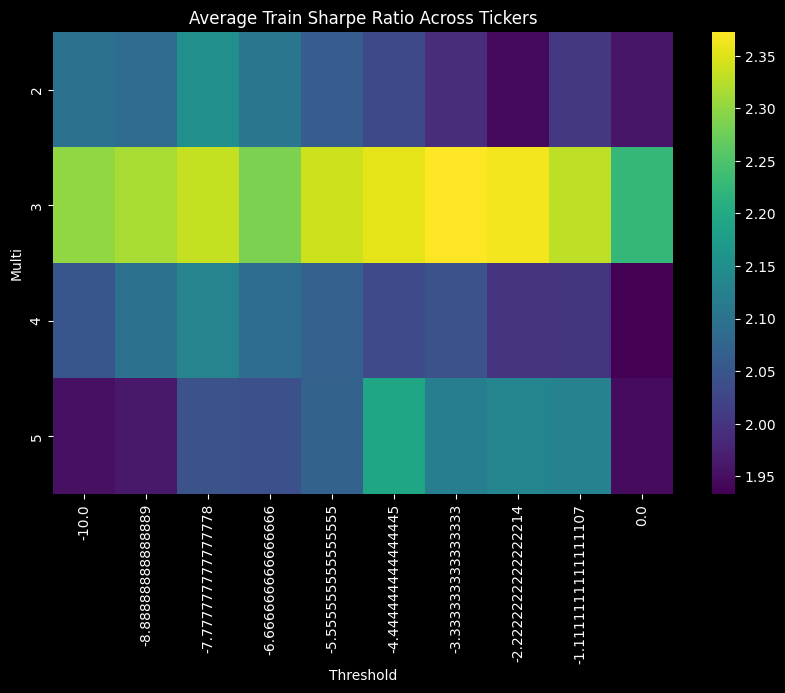


Averaged params → Multi: 3, Threshold: -4.667


In [ ]:
datas = joblib.load('/Users/leoinv/Documents/CODE/BACKTEST/data/1h.joblib')

train_ratio = 0.7
multi = np.linspace(2, 5, 10, dtype=int)
thresholds = np.linspace(-10, 0, 10)

# Step 1: Sweep Sharpe across all tickers' train sets
sweep_results = []
i = 0
for ticker, data in datas.items():
    i += 1
    if i > 10:
        break
    if ticker == 'XLMUSDT':
        continue
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data.set_index('Date', inplace=True)
    data = data.dropna()

    if len(data) <= 30000:
        continue

    # Split train/test
    split_idx = int(len(data) * train_ratio)
    train_data = data.iloc[:split_idx]

    for m in multi:
        for th in thresholds:
            bt_train = Backtest(train_data, ElderImpulseADX,
                                cash=1000000000, commission=.0005)
            stats = bt_train.run(multi=m, threshold=th)
            sweep_results.append((m, th, stats['Sortino Ratio'], ticker))

# Step 2: Average Sharpe for each param pair
df_sweep = pd.DataFrame(sweep_results, columns=['Multi', 'Threshold', 'Sharpe', 'Ticker'])
avg_sweep = df_sweep.groupby(['Multi', 'Threshold'])['Sharpe'].mean().reset_index()

# Step 3: Create heatmap
pivot = avg_sweep.pivot(index='Multi', columns='Threshold', values='Sharpe')

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=False)
plt.title("Average Train Sharpe Ratio Across Tickers")
plt.show()

# Get top 3 rows by Sharpe
top5 = avg_sweep.nlargest(5, 'Sharpe')

# Average their parameters
best_multi = int(round(top5['Multi'].mean()))
best_threshold = top5['Threshold'].mean()

print(f"\nAveraged params → Multi: {best_multi}, Threshold: {best_threshold:.3f}")

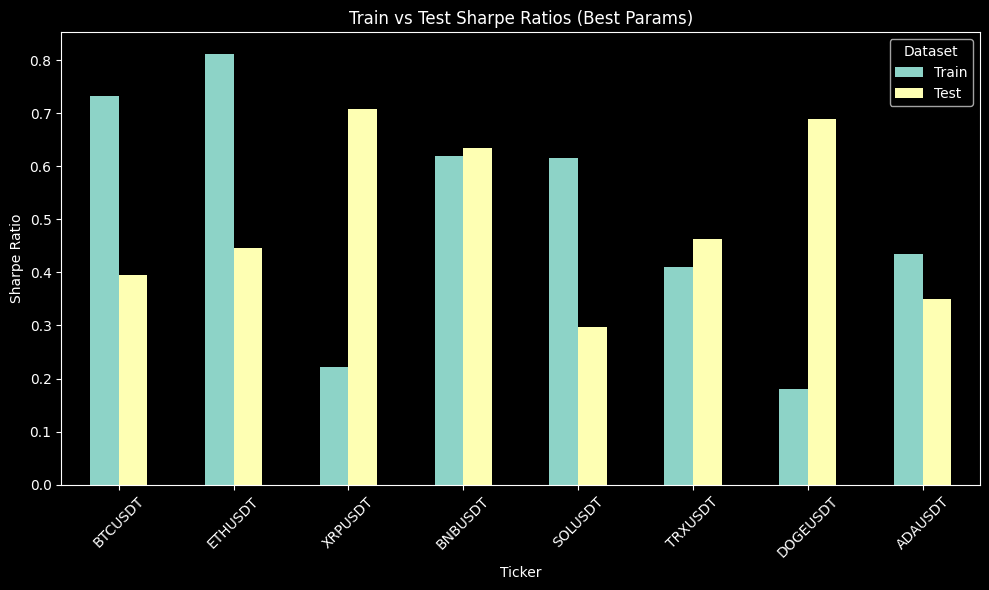

In [ ]:
# Step 5: Run test set with best params
train_results = {}
test_results = {}

train_equities = {}
test_equities = {}

i = 0
for ticker, data in datas.items():
    if ticker == 'XLMUSDT':
        continue
    i += 1
    if i > 10:
        break
    data = data.dropna()

    if len(data) <= 30000:
        continue

    split_idx = int(len(data) * train_ratio)
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]

    # Train run
    bt_train = Backtest(train_data, ElderImpulseADX, cash=1000000000, commission=.0005)
    stats_train = bt_train.run(multi=best_multi, threshold=best_threshold)
    train_results[ticker] = stats_train['Sharpe Ratio']
    train_equities[ticker] = stats_train['_equity_curve']['Equity'].pct_change().cumsum() + 1

    # Test run
    bt_test = Backtest(test_data, ElderImpulseADX, cash=1000000000, commission=.0005)
    stats_test = bt_test.run(multi=best_multi, threshold=best_threshold)
    test_results[ticker] = stats_test['Sharpe Ratio']
    test_equities[ticker] = stats_test['_equity_curve']['Equity'].pct_change().cumsum() + 1

# Step 6: Compare Train vs Test Sharpe
df_results = pd.DataFrame({
    "Train": pd.Series(train_results),
    "Test": pd.Series(test_results)
}).dropna(how="all")

df_results.plot(kind='bar', figsize=(10, 6))
plt.title("Train vs Test Sharpe Ratios (Best Params)")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

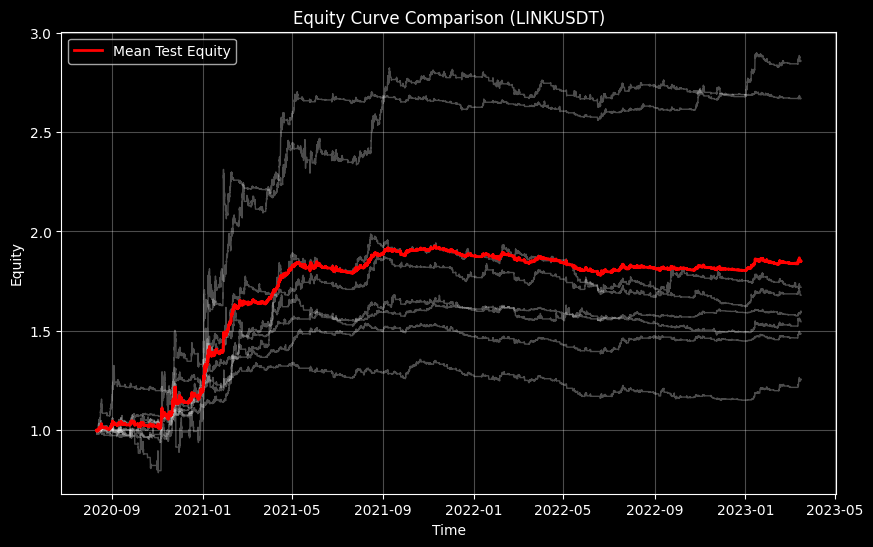

               CAR  Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio
BTCUSDT   0.091979    0.088339      0.998095     -0.153051      0.600971
ETHUSDT   0.165126    0.081685      1.870116     -0.100448      1.643886
XRPUSDT   0.234470    0.187673      1.128194     -0.153343      1.529063
BNBUSDT   0.197744    0.085277      2.116034     -0.054833      3.606271
SOLUSDT   0.499296    0.360668      1.122955     -0.314294      1.588627
TRXUSDT   0.183272    0.149306      1.128741     -0.121045      1.514087
DOGEUSDT  0.461844    0.203893      1.866476     -0.138777      3.327958
ADAUSDT   0.221105    0.150607      1.326399     -0.138509      1.596329

Mean: CAR             0.256855
Volatility      0.163431
Sharpe Ratio    1.444626
Max Drawdown   -0.146788
Calmar Ratio    1.925899
dtype: float64


In [ ]:
df_train = pd.DataFrame(train_equities).dropna().pct_change().cumsum() + 1
df_test = pd.DataFrame(test_equities)

# Calculate mean test equity curve
mean_train_equity = df_train.mean(axis=1)

# Plot
plt.figure(figsize=(10, 6))

# Plot test equities (all in white)
for col in df_train.columns:
    plt.plot(df_train[col], color='white', alpha=0.3, linewidth=1, label='_nolegend_')

# Plot mean of test equities in red
plt.plot(mean_train_equity, color='red', linewidth=2, label='Mean Test Equity')

# Titles and style
plt.title(f"Equity Curve Comparison ({ticker})")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(True, alpha=0.3)
plt.legend()

# Black background for contrast
plt.gca().set_facecolor('black')
plt.show()


from utils import performance_metrics
results = {}
for ticker in df_train.columns:
   results[ticker] = performance_metrics(df_train[ticker], periods_per_year=24* 365)

result_df = pd.DataFrame(results).T
print(result_df)
print(f"\nMean: {result_df.mean()}")

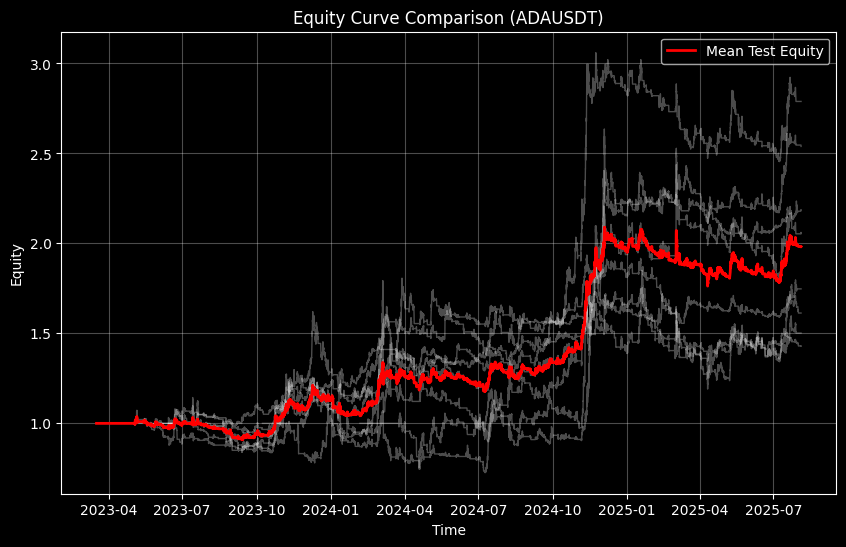

               CAR  Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio
BTCUSDT   0.161114    0.232851      0.641555     -0.232637      0.692553
ETHUSDT   0.221808    0.256369      0.781456     -0.360746      0.614860
XRPUSDT   0.535043    0.389107      1.101447     -0.429995      1.244299
BNBUSDT   0.271909    0.289233      0.831618     -0.244468      1.112249
SOLUSDT   0.312634    0.411531      0.661083     -0.356481      0.877000
TRXUSDT   0.440813    0.194774      1.875138     -0.238370      1.849282
DOGEUSDT  0.754391    0.386806      1.453333     -0.258167      2.922101
ADAUSDT   0.389908    0.400889      0.821310     -0.416371      0.936443

Mean: CAR             0.385953
Volatility      0.320195
Sharpe Ratio    1.020868
Max Drawdown   -0.317154
Calmar Ratio    1.281098
dtype: float64


In [ ]:
# Calculate mean test equity curve
mean_test_equity = df_test.mean(axis=1)

# Plot
plt.figure(figsize=(10, 6))

# Plot test equities (all in white)
for col in df_test.columns:
    plt.plot(df_test[col], color='white', alpha=0.3, linewidth=1, label='_nolegend_')

# Plot mean of test equities in red
plt.plot(mean_test_equity, color='red', linewidth=2, label='Mean Test Equity')

# Titles and style
plt.title(f"Equity Curve Comparison ({ticker})")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(True, alpha=0.3)
plt.legend()

# Black background for contrast
plt.gca().set_facecolor('black')
plt.show()

from utils import performance_metrics
results = {}
for ticker in df_test.columns:
   results[ticker] = performance_metrics(df_test[ticker], periods_per_year=24* 365)


result_df = pd.DataFrame(results).T
print(result_df)
print(f"\nMean: {result_df.mean()}")